In [56]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization

In [57]:
start='2007-01-01'
end='2017-12-31'
window = 9
predictedDays = 60
targetColumn = 47

In [58]:
df1=pd.read_csv('data/final_data.csv', index_col=0)
df1.head()

,newsSentiment,Bullish,Neutral,Bearish,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,High_DBC,...,Adj Close_XLF,RSI_XLF,High_XRT,Low_XRT,Open_XRT,Close_XRT,Volume_XRT,Adj Close_XRT,RSI_XRT,ARIMAPred
Date,,,,,,,,,,,,,,,,,,,,,
2007-02-22,0.42,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.150000,...,18.043667,56.610596,21.969999,21.700001,21.895000,21.830000,623600.0,18.426498,69.379187,145.966158
2007-02-23,0.04,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.420000,...,17.875931,48.687708,21.764999,21.590000,21.764999,21.719999,1688400.0,18.333652,64.632872,145.861243
2007-02-26,0.33,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.490000,...,17.746534,43.616393,21.745001,21.510000,21.745001,21.594999,528600.0,18.228136,59.639849,145.337678
2007-02-27,0.31,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.340000,...,16.917431,25.377127,21.305000,20.645000,21.215000,20.705000,1533600.0,17.476902,37.454108,145.217983
2007-02-28,0.36,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.299999,...,17.228941,36.176334,21.070000,20.670000,20.674999,21.000000,759600.0,17.725908,44.785816,139.713898


In [59]:
target=pd.DataFrame(df1[df1.columns[targetColumn]])
target.columns=(['Closing_price'])
target.head()

,Closing_price
Date,
2007-02-22,145.869995
2007-02-23,145.300003
2007-02-26,145.169998
2007-02-27,139.500000
2007-02-28,140.929993


In [60]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(np.array(target['Closing_price']).reshape(-1,1))
scaled_target= target_scaler.transform(np.array(target['Closing_price']).reshape(-1,1))
scaled_target=[scaled_target[i][0] for i in range(len(scaled_target))]

In [61]:
df=df1.copy()
df=pd.concat([df])
df.head()

,newsSentiment,Bullish,Neutral,Bearish,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,High_DBC,...,Adj Close_XLF,RSI_XLF,High_XRT,Low_XRT,Open_XRT,Close_XRT,Volume_XRT,Adj Close_XRT,RSI_XRT,ARIMAPred
Date,,,,,,,,,,,,,,,,,,,,,
2007-02-22,0.42,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.150000,...,18.043667,56.610596,21.969999,21.700001,21.895000,21.830000,623600.0,18.426498,69.379187,145.966158
2007-02-23,0.04,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.420000,...,17.875931,48.687708,21.764999,21.590000,21.764999,21.719999,1688400.0,18.333652,64.632872,145.861243
2007-02-26,0.33,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.490000,...,17.746534,43.616393,21.745001,21.510000,21.745001,21.594999,528600.0,18.228136,59.639849,145.337678
2007-02-27,0.31,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.340000,...,16.917431,25.377127,21.305000,20.645000,21.215000,20.705000,1533600.0,17.476902,37.454108,145.217983
2007-02-28,0.36,0.5385,0.2385,0.2231,0.48095,0.3154,0.384907,0.488293,0.281522,25.299999,...,17.228941,36.176334,21.070000,20.670000,20.674999,21.000000,759600.0,17.725908,44.785816,139.713898


In [62]:
#Scalling all columns
#------------------------------------------------------------------------------------------------------------------------
scalers=[]
for col in df.columns:
    name = 'scaler_'+str(col)
    scaler = MinMaxScaler(feature_range=(0, 1))
    s= scaler.fit_transform(np.array(df[col]).reshape(-1,1))
    s= [s[i][0] for i in range(len(s))]
    df[col]=s
    scalers.append(scaler)
    with open(name+'.pickle', 'wb') as t:
        pickle.dump(scaler, t, protocol=pickle.HIGHEST_PROTOCOL)
    
df.head()

C:\Users\ganev\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ganev\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,newsSentiment,Bullish,Neutral,Bearish,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,High_DBC,...,Adj Close_XLF,RSI_XLF,High_XRT,Low_XRT,Open_XRT,Close_XRT,Volume_XRT,Adj Close_XRT,RSI_XRT,ARIMAPred
Date,,,,,,,,,,,,,,,,,,,,,
2007-02-22,0.672515,0.792877,0.35776,0.131414,0.826033,0.843836,1.0,1.0,1.0,0.381336,...,0.615609,0.582446,0.323006,0.331671,0.327005,0.327823,0.006162,0.285949,0.797942,0.389332
2007-02-23,0.450292,0.792877,0.35776,0.131414,0.826033,0.843836,1.0,1.0,1.0,0.389113,...,0.608668,0.470457,0.318266,0.329118,0.323996,0.325280,0.019969,0.283716,0.721923,0.388808
2007-02-26,0.619883,0.792877,0.35776,0.131414,0.826033,0.843836,1.0,1.0,1.0,0.391129,...,0.603313,0.398774,0.317803,0.327262,0.323533,0.322390,0.004930,0.281177,0.641952,0.386190
2007-02-27,0.608187,0.792877,0.35776,0.131414,0.826033,0.843836,1.0,1.0,1.0,0.386809,...,0.569002,0.140963,0.307630,0.307193,0.311263,0.301815,0.017962,0.263105,0.286616,0.385591
2007-02-28,0.637427,0.792877,0.35776,0.131414,0.826033,0.843836,1.0,1.0,1.0,0.385657,...,0.581893,0.293609,0.302197,0.307773,0.298761,0.308635,0.007925,0.269096,0.404044,0.358069


In [63]:
#PCA
#-----------------------------------------------------------------------------------------------------------------------
pca = PCA(n_components=12)
df = pd.DataFrame(pca.fit_transform(df), index = df.index)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
Date,,,,,,,,,,,,
2007-02-22,-0.539529,1.586975,0.316692,-0.503788,-0.777660,-0.235312,-0.035631,0.499379,0.642649,-0.091391,0.022307,-0.124042
2007-02-23,-0.579385,1.551734,0.385382,-0.352435,-0.734451,-0.183459,0.007101,0.593143,0.680442,-0.181269,0.022015,-0.171534
2007-02-26,-0.579298,1.532547,0.389438,-0.298397,-0.695203,-0.165130,0.047937,0.596993,0.688227,-0.223149,0.025867,-0.208759
2007-02-27,-0.720684,1.315592,0.845399,0.370774,-0.701007,0.137709,-0.147204,0.799329,0.580923,-0.465869,-0.121063,-0.013860
2007-02-28,-0.715068,1.358493,0.711847,0.131224,-0.689732,-0.000487,-0.042392,0.757642,0.596206,-0.405516,-0.125088,-0.060517


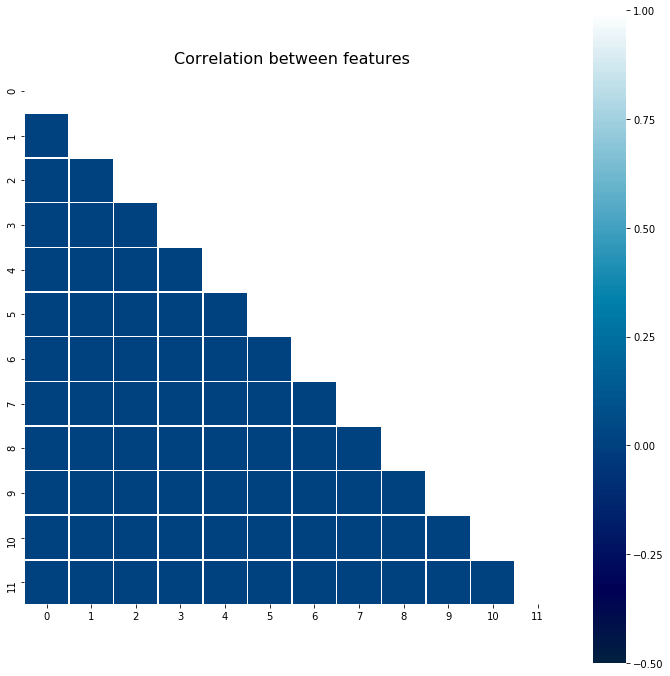

In [64]:
#PCA should eliminate correlation between features : Checking for correlation
#---------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(12,12))
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0, vmin=-0.5, square=True, linewidths=.5, cmap='ocean')
plt.title('Correlation between features', fontdict={'fontsize': 16})
plt.show()

In [65]:
#splitting to train and test
#------------------------------------------------------------------------------------------------------------------------
data=df.copy()# making a copy in case we need to get back to original data
array_data=data.values
len_train=int(len(array_data)-predictedDays)
train=array_data[:len_train]
scaled_target_train=scaled_target[:len_train]
test=array_data[len_train:]
scaled_target_test=scaled_target[len_train:]

In [66]:
#Train Set
#---------------------------------------------------------------------------------------------------------------------------
x_train_total, y_train_total = [],[]
for i in range(window+1,len(train)):
    x_train_total.append(train[i-(window+1):i-1])
    y_train_total.append(scaled_target_train[i])
    
x_train_total, y_train_total=np.array(x_train_total), np.array(y_train_total)

In [67]:
#Test Set
#-----------------------------------------------------------------------------------------------------------------
x_test_total, y_test_total = [],[]
for i in range(window+1,len(test)):
    x_test_total.append(test[i-(window+1):i-1])
    y_test_total.append(scaled_target_test[i])
    
x_test_total, y_test_total=np.array(x_test_total), np.array(y_test_total)

In [68]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True, input_shape=(x_train_total.shape[1],x_train_total.shape[2])))
model.add(LSTM(units=100))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 9, 100)            45200     
_________________________________________________________________
lstm_88 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 101       
Total params: 125,701
Trainable params: 125,701
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.fit(x_train_total, y_train_total, epochs=7, batch_size=1, verbose=1)

Epoch 1/7
2664/2664 [==============================] - 84s 32ms/step - loss: 0.0025
Epoch 2/7
2664/2664 [==============================] - ETA: 0s - loss: 6.3795e-04- ETA: 0s - l - 70s 26ms/step - loss: 6.3771e-04
Epoch 3/7
2664/2664 [==============================] - 70s 26ms/step - loss: 4.4919e-04
Epoch 4/7
2664/2664 [==============================] - ETA: 0s - loss: 3.6592e-04- ETA: 0s - loss: 3.6620e- - 69s 26ms/step - loss: 3.6580e-04
Epoch 5/7
2664/2664 [==============================] - 70s 26ms/step - loss: 3.2495e-04
Epoch 6/7
2664/2664 [==============================] - 70s 26ms/step - loss: 2.8385e-04 2
Epoch 7/7
2664/2664 [==============================] - 71s 27ms/step - loss: 2.6240e-04


In [70]:
closing_price = model.predict(x_test_total)
closing_price = target_scaler.inverse_transform(closing_price)

In [71]:
y_test_total=target_scaler.inverse_transform(y_test_total.reshape(-1,1))
rms=np.sqrt(np.mean(np.power((y_test_total-closing_price),2)))
print('The Root Mean Squared error is :',rms)

The Root Mean Squared error is : 1.6698346570505962


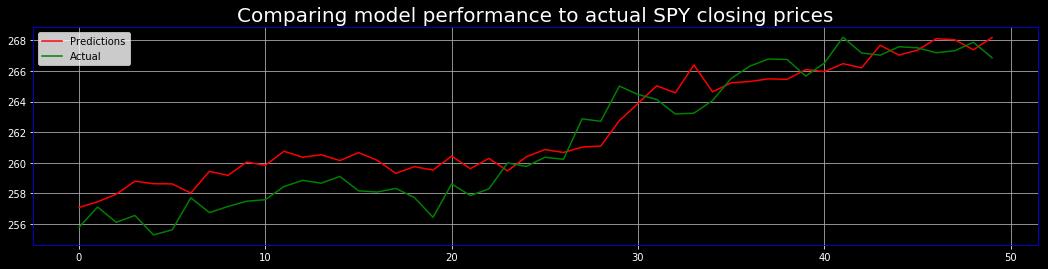

In [81]:
fig = plt.figure(figsize=(18,4),facecolor = 'k')
ax=plt.subplot2grid((4,4),(0,0),rowspan = 4, colspan = 4,facecolor='k')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
ax.spines['bottom'].set_color("b")
ax.spines['top'].set_color("b")
ax.spines['left'].set_color("b")
ax.spines['right'].set_color("b")
ax.grid(True)
ax.plot( closing_price, color ='r', label = 'Predictions')
ax.plot(y_test_total, label = 'Actual', color ='g')
plt.title('Comparing model performance to actual SPY closing prices',fontsize=20, color='w')
plt.legend()

## K-Fold Cross Validation

In [35]:
#K-Fold Cross-Validation
#-------------------------------------------------------------------------------------------------------

#getting the original data back
data=df.copy()# making a copy in case we need to get back to original data
array_data=data.values
len_train=int(len(array_data)-predictedDays)
train=array_data[:len_train]
scaled_target_train=scaled_target[:len_train]
test=array_data[len_train:]
scaled_target_test=scaled_target[len_train:]

#K-fold Cross-validation
lenData=len(x_train_total)
rmse, number_train = [],[]
for i in range(1,int((lenData-60)/60)):
    trainValues=60+(i-1)*60
    x_train= x_train_total[:trainValues]
    y_train= y_train_total[:trainValues]
   
    x_train, y_train=np.array(x_train), np.array(y_train)
   
    x_test=x_train_total[trainValues:trainValues+60]
    y_test=y_train_total[trainValues:trainValues+60]
   
    x_train, y_train=np.array(x_train), np.array(y_train)

    x_test, y_test=np.array(x_test), np.array(y_test)
   
    model = Sequential()
    model.add(LSTM(units=100,return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(LSTM(units=100))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    print(i, 'out of ', int((lenData-60)/60) )
    model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=1)
   
    closing_price = model.predict(x_test)
    closing_price = target_scaler.inverse_transform(closing_price)
   
    y_test=target_scaler.inverse_transform(y_test.reshape(-1,1))
    rms=np.sqrt(np.mean(np.power((y_test-closing_price),2)))
    print('The Root Mean Squared error is :',rms)
   
    rmse.append(rms)
    number_train.append(trainValues)
   

1 out of  43
Epoch 1/5
60/60 [==============================] - 3s 43ms/step - loss: 0.0051
Epoch 2/5
60/60 [==============================] - 1s 17ms/step - loss: 1.2522e-04
Epoch 3/5
60/60 [==============================] - 1s 18ms/step - loss: 5.5111e-05
Epoch 4/5
60/60 [==============================] - 1s 16ms/step - loss: 3.7392e-05
Epoch 5/5
60/60 [==============================] - 1s 16ms/step - loss: 7.2644e-05
The Root Mean Squared error is : 4.423114384116675
2 out of  43
Epoch 1/5
120/120 [==============================] - 4s 32ms/step - loss: 0.0036
Epoch 2/5
120/120 [==============================] - 2s 16ms/step - loss: 2.2092e-04
Epoch 3/5
120/120 [==============================] - 2s 16ms/step - loss: 2.6643e-04
Epoch 4/5
120/120 [==============================] - 2s 17ms/step - loss: 2.6412e-04
Epoch 5/5
120/120 [==============================] - ETA: 0s - loss: 2.3046e-04- ETA: 0s - l - 2s 17ms/step - loss: 2.2856e-04
The Root Mean Squared error is : 4.71988243704177

1980/1980 [==============================] - 58s 29ms/step - loss: 0.0021
Epoch 2/5
1980/1980 [==============================] - 48s 24ms/step - loss: 5.6230e-04 0s - loss - ETA: 0s - loss: 5.6220e-0
Epoch 3/5
1980/1980 [==============================] - 48s 24ms/step - loss: 4.2623e-04
Epoch 4/5
1980/1980 [==============================] - 45s 23ms/step - loss: 3.5393e-04
Epoch 5/5
1980/1980 [==============================] - 47s 24ms/step - loss: 3.0748e-04
The Root Mean Squared error is : 11.873227234648628
34 out of  43
Epoch 1/5
2040/2040 [==============================] - 58s 29ms/step - loss: 0.0019
Epoch 2/5
2040/2040 [==============================] - 47s 23ms/step - loss: 5.2633e-04
Epoch 3/5
2040/2040 [==============================] - 48s 24ms/step - loss: 3.8591e-04
Epoch 4/5
2040/2040 [==============================] - 47s 23ms/step - loss: 3.2155e-04
Epoch 5/5
2040/2040 [==============================] - 48s 24ms/step - loss: 2.7663e-04 0s - loss: 
The Root Mean Squared 

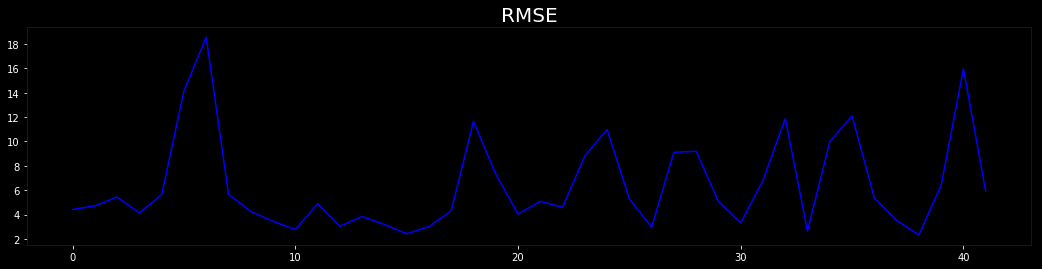

In [54]:
fig = plt.figure(figsize=(18,4),facecolor = 'k')
ax=plt.subplot2grid((4,4),(0,0),rowspan = 4, colspan = 4,facecolor='k')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
ax.spines['bottom'].set_color("b")
ax.spines['top'].set_color("b")
ax.spines['left'].set_color("b")
ax.spines['right'].set_color("b")
plt.title('RMSE',color='w',fontsize=20)
ax.plot(rmse,color='b')

## Conclusion: 
- Root Mean Square Error does not exhibit a trend and based on length of training set.
- Lowest valued of RMSE tend to be achieved between 600 and 900 days for training. 
- The lowest RMSE is at about 2 points indicating that the predictions can potentially be useful to a trader in certain market circumstances.

## Next Steps:

- Retrain the model with time window between 600 and 900
- Backtest to check for profitability